In [1]:
import z5py
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage.segmentation import find_boundaries, watershed
from skimage.morphology import remove_small_objects


from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib import colors

## Try to improve results of multicut

### Open raw and segmentation

In [2]:
scratch_dir = Path("/scratch/buglakova")
predictions_dir = scratch_dir / "F107_bin2_619-639_predictions"

In [3]:
n5_path = predictions_dir / "full_raw.n5"
pred_n5_path = predictions_dir / "full_predictions.n5"
multicut_n5_path = predictions_dir / "full_multicut_beta_new.n5"

In [4]:
f = z5py.File(pred_n5_path, "r")
f_raw = z5py.File(n5_path, "r")
f_multicut = z5py.File(multicut_n5_path, "r")

In [5]:
"raw/raw_data" in f_raw.keys()

True

In [6]:
def read_volume(f: z5py.File, key: str, roi: np.lib.index_tricks.IndexExpression = np.s_[:]):
    try:
        ds = f[key]
    except KeyError:
        print(f"No key {key} in file {f.filename}")
        print_key_tree(f)
        return None
        
    ds.n_threads = 8
    print(f"Reading roi {roi} of volume {key} from {f.filename}")
    vol = ds[roi]
    print(f"Read volume with shape {vol.shape}, data type {vol.dtype}")
    
    return vol

In [9]:
roi = np.s_[235:300, :, :]

raw = read_volume(f_raw, "raw/raw_data", roi)
boundaries = read_volume(f, "predictions/boundaries", roi)
extra = read_volume(f, "predictions/extracellular", roi)
multicut = read_volume(f_multicut, f"segmentation/multicut_0.6", roi)

Reading roi (slice(235, 300, None), slice(None, None, None), slice(None, None, None)) of volume raw/raw_data from /scratch/buglakova/F107_bin2_619-639_predictions/full_raw.n5
Read volume with shape (65, 1506, 1647), data type uint8
Reading roi (slice(235, 300, None), slice(None, None, None), slice(None, None, None)) of volume predictions/boundaries from /scratch/buglakova/F107_bin2_619-639_predictions/full_predictions.n5
Read volume with shape (65, 1506, 1647), data type float32
Reading roi (slice(235, 300, None), slice(None, None, None), slice(None, None, None)) of volume predictions/extracellular from /scratch/buglakova/F107_bin2_619-639_predictions/full_predictions.n5
Read volume with shape (65, 1506, 1647), data type float32
Reading roi (slice(235, 300, None), slice(None, None, None), slice(None, None, None)) of volume segmentation/multicut_0.6 from /scratch/buglakova/F107_bin2_619-639_predictions/full_multicut_beta_new.n5
Read volume with shape (65, 1506, 1647), data type uint32


### Preprocess extracellular prediction

In [10]:
min_extra_size = 100000

extra_bin = extra > 0.9
remove_small_objects(extra_bin, min_size=min_extra_size, out=extra_bin)
extra_bin_contours = find_boundaries(extra_bin)

### Prepare multicut segmentation for plotting

In [11]:
multicut_contours = find_boundaries(multicut)

### Multicut mask size distribution

In [12]:
def fast_count_unique(array: np.array):
    if array.dtype is not np.int64:
        print(f"array type is {array.dtype}. Converting to int64, possibly can cause errors")
    n_features = int(np.max(array))
    counts = np.bincount(array.flatten().astype(np.int64), minlength=n_features + 1)
    return counts

In [13]:
counts = fast_count_unique(multicut)

array type is uint32. Converting to int64, possibly can cause errors


In [14]:
print(len(counts[counts > 0]))

11100


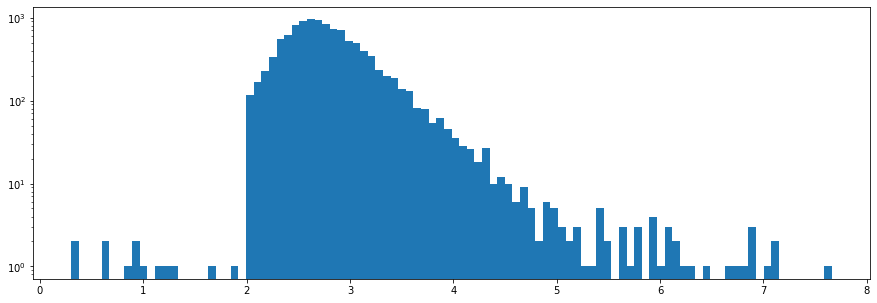

In [15]:
plt.figure(figsize=(15, 5))
plt.hist(np.log10(counts[counts > 0]), bins=100, log=True);

### How it looks before postprocessing

In [16]:
print(f"Dataset size: {multicut.shape}")

Dataset size: (65, 1506, 1647)


In [17]:
def create_cmap(color):
    transparent_black = [0, 0, 0, 0]
    return ListedColormap(np.array([transparent_black, color]))

def plot_segmentation(raw, seg, boundaries_bin=None, extra_bin=None, z=0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 20))
    
    ax.imshow(raw[z, :, :], cmap="gray")
    if boundaries_bin is not None:
        boundaries_cmap = create_cmap(colors.to_rgb("dodgerblue"))
        ax.imshow(boundaries_bin[z, :, :], cmap=boundaries_cmap, alpha=0.5)

    if extra_bin is not None:
        extra_cmap = create_cmap(colors.to_rgb("turquoise"))
        ax.imshow(extra_bin[z, :, :], cmap=extra_cmap, alpha=0.5)

    seg_cmap = create_cmap(colors.to_rgb("crimson"))
    seg_contours = find_boundaries(seg)
    ax.imshow(seg_contours[z, :, :], cmap=seg_cmap)
    # ax.imshow(seg[z, :, :], alpha=1)

    plt.show()

/tmp/ipykernel_164648/4056058527.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ListedColormap(np.array([transparent_black, color]))


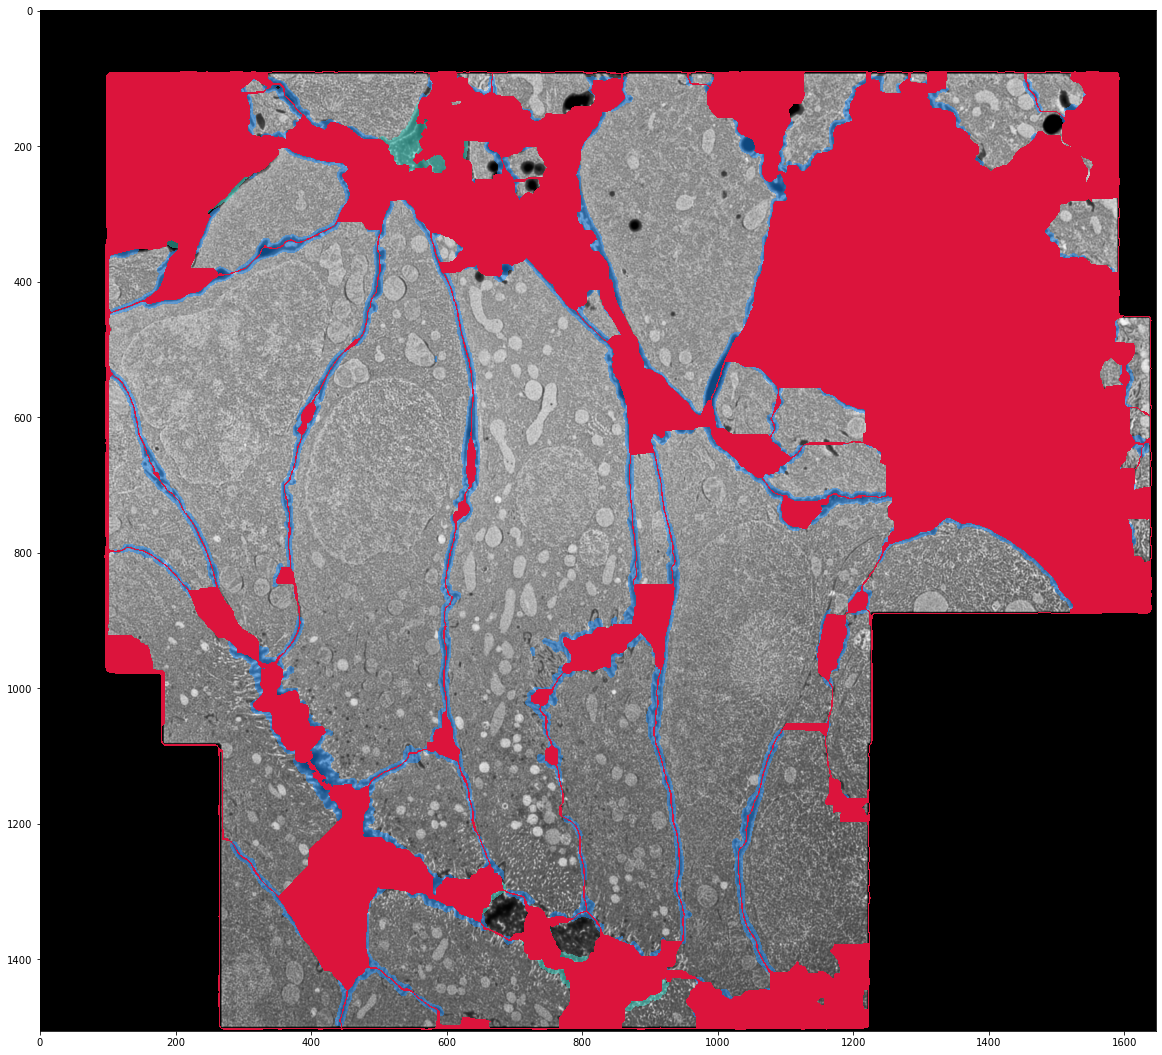

In [18]:
plot_segmentation(raw, multicut, boundaries_bin=boundaries > 0.9, extra_bin=extra_bin, z=30)

### Distribution of mask sizes  
Maybe per slice somehow, because otherwise it crashes

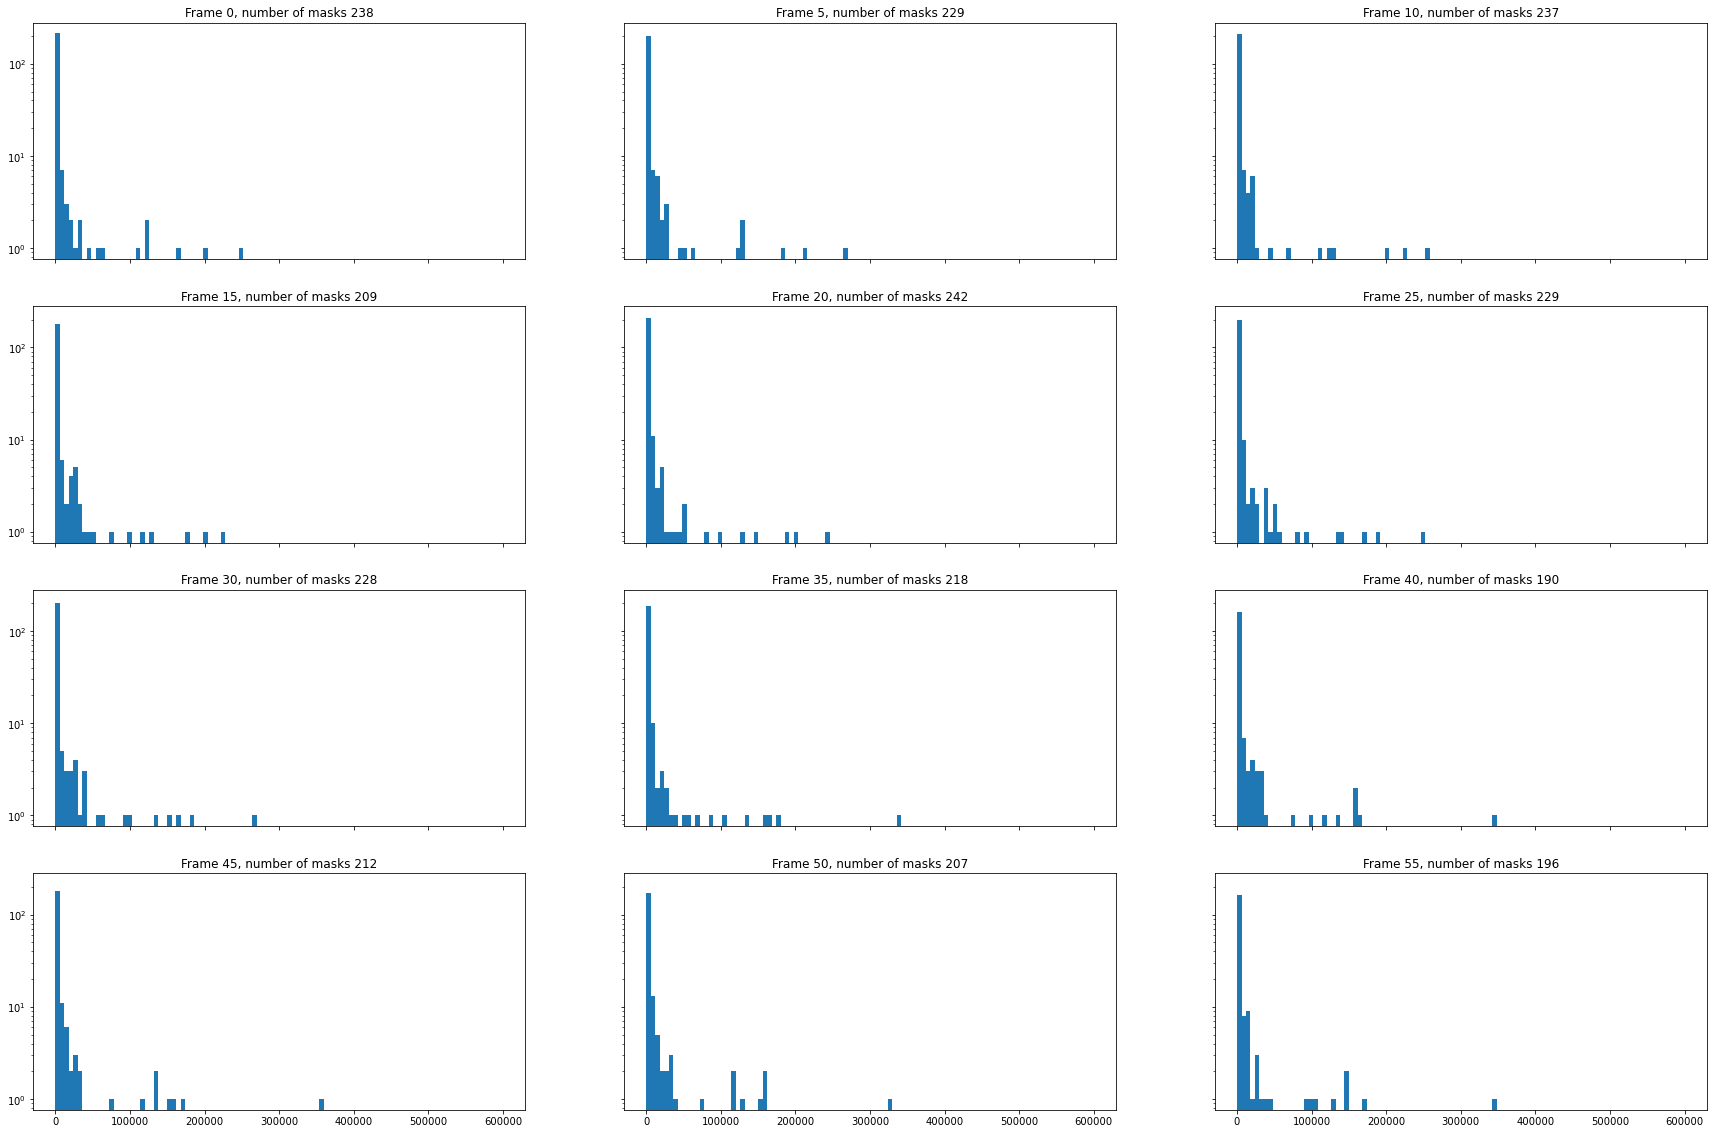

In [19]:
stride = 5
n_images = multicut.shape[0] // stride
n_cols = 3
n_rows = n_images // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 5), sharex=True, sharey=True)

for n, ax in zip(range(0, multicut.shape[0], stride), axes.flat):
    mask_sizes = [np.count_nonzero(multicut[n, :, :] == i) for i in np.unique(multicut[n, :, :])[1:]]
    ax.hist(mask_sizes, bins=100, log=True, range=(0, 600000));
    ax.set_title(f"Frame {n}, number of masks {len(mask_sizes)}")

### Set extracellular space mask and background

In [20]:
def get_zero_component(img: np.ndarray):
    bg = label(img == 0)
    component_sizes = [np.count_nonzero(bg == i) for i in np.unique(bg)[1:]]
    bg_ind = np.argmax(component_sizes) + 1
    bg = (bg == bg_ind)
    fg = (bg != bg_ind)
    return fg


def get_fg_mask(raw: np.ndarray):
    print("Compute foreground mask")
    print("Raw data shape: ", raw.shape)
    fg_mask = np.array([get_zero_component(img) for img in raw])
    return fg_mask

In [21]:
seg = multicut.copy()
fg_mask = get_fg_mask(raw)
seg = seg + 2
seg[extra_bin] = 2
seg[~fg_mask] = 0

Compute foreground mask
Raw data shape:  (65, 1506, 1647)


### Try to filter by size

In [22]:
def apply_size_filter(segmentation, boundaries, raw, size_filter, exclude=None):
    """ Apply size filter to segmentation.
    Arguments:
        segmentation [np.ndarray] - input segmentation.
        input_ [np.ndarray] - input height map.
        size_filter [int] - minimal segment size.
        exclude [list] - list of segment ids that will not be size filtered (default: None).
    Returns:
        np.ndarray - size filtered segmentation
        int - max id of size filtered segmentation
    """
    print("Find labels with small sizes")
    ids, sizes = np.unique(segmentation, return_counts=True)
    filter_ids = ids[sizes < size_filter]
    if exclude is not None:
        filter_ids = filter_ids[np.logical_not(np.in1d(filter_ids, exclude))]
    filter_mask = np.in1d(segmentation, filter_ids).reshape(segmentation.shape)
    segmentation[filter_mask] = 0
    
    print("Get foreground mask")
    fg_mask = get_fg_mask(raw)
    # compactness??
    segmentation = watershed(boundaries, markers=segmentation, mask=fg_mask)
    return segmentation

In [23]:
min_segment_size = 10000

/tmp/ipykernel_164648/4056058527.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ListedColormap(np.array([transparent_black, color]))


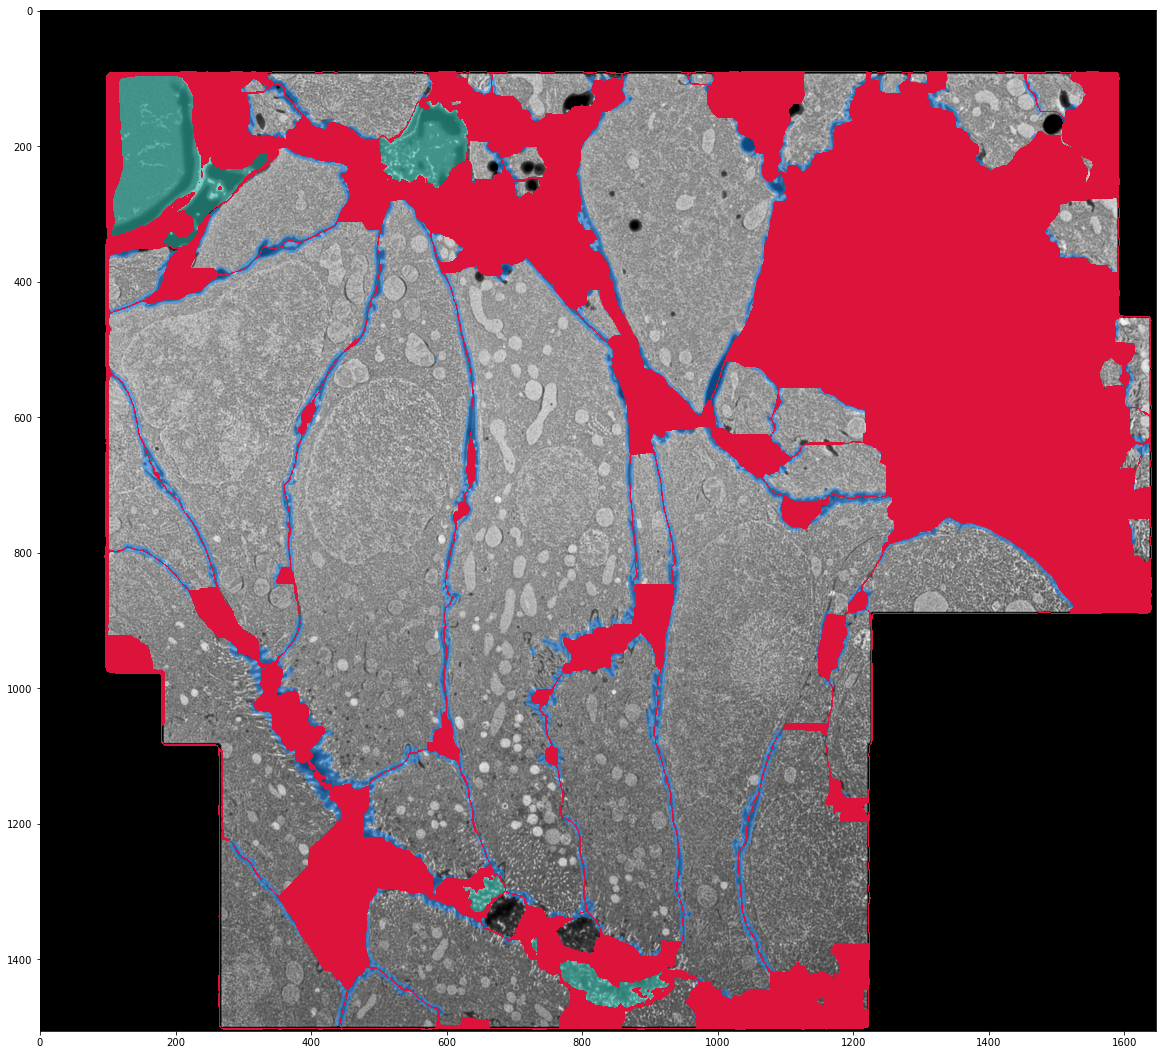

In [24]:
plot_segmentation(raw, seg, boundaries_bin=boundaries > 0.9, extra_bin=extra_bin, z=30)

In [25]:
seg_filtered = apply_size_filter(seg, boundaries, raw, min_segment_size, exclude=None)

Find labels with small sizes
Get foreground mask
Compute foreground mask
Raw data shape:  (65, 1506, 1647)


In [27]:
seg_filtered.shape

(65, 1506, 1647)

/tmp/ipykernel_164648/4056058527.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ListedColormap(np.array([transparent_black, color]))


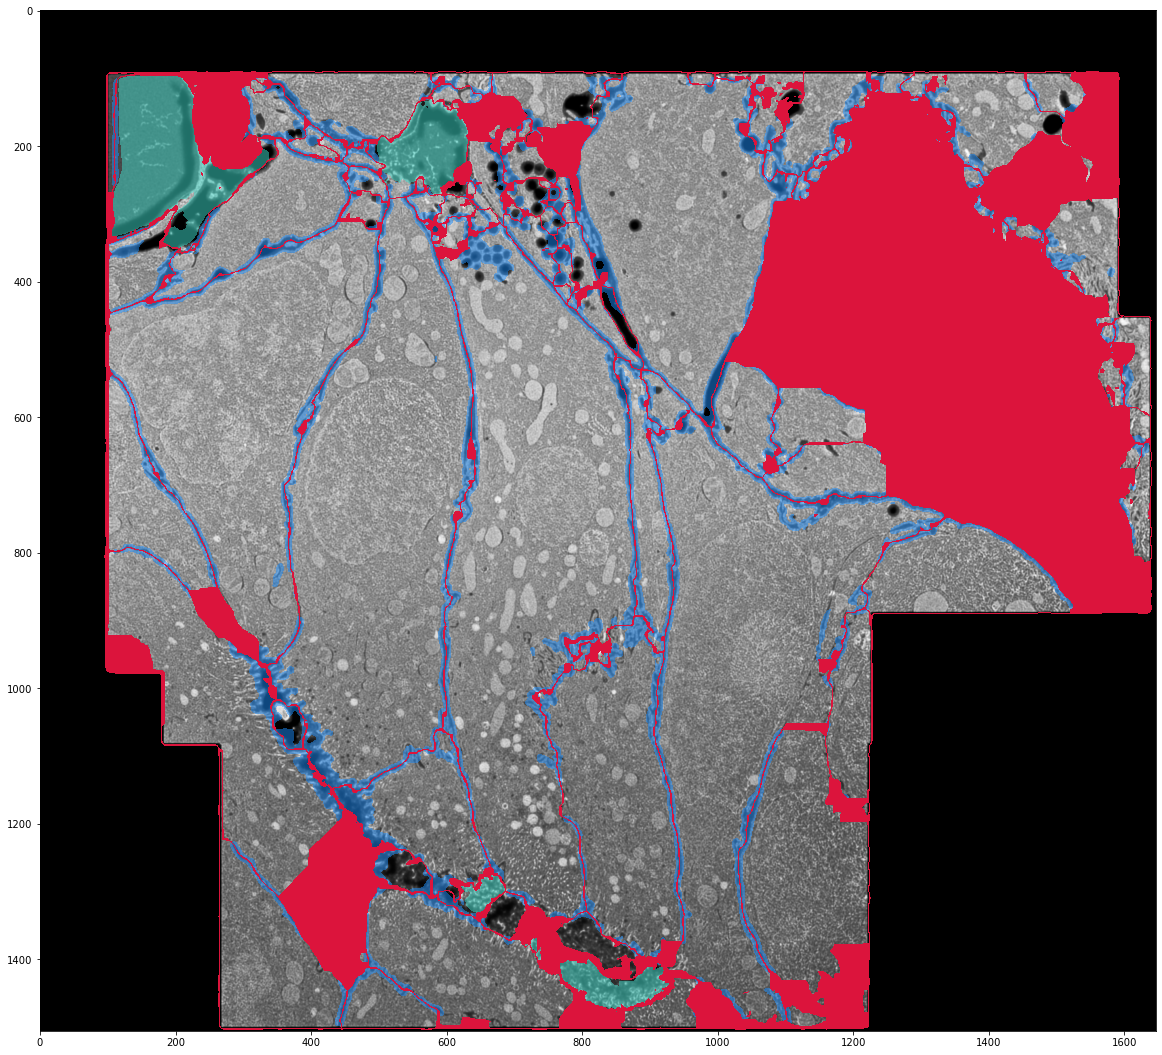

In [28]:
plot_segmentation(raw, seg_filtered, boundaries_bin=boundaries > 0.9, extra_bin=extra_bin, z=30)

In [37]:
seg_filtered = seg_filtered[0]

In [42]:
def write_volume(f, arr: np.array, key, chunks=(1, 512, 512)):
    shape = arr.shape
    compression = "gzip"
    dtype = arr.dtype

    ds = f.create_dataset(key, shape=shape, compression=compression,
                                chunks=chunks, dtype=dtype)
    ds.n_threads = 8
    ds[:] = arr

In [44]:
f_out = z5py.File(predictions_dir / "filter_size_235:300.n5", "a")
# write_volume(f_out, raw, "raw/raw")
write_volume(f_out, seg, "segmentation/multicut")

write_volume(f_out, seg_filtered, "segmentation/filtered")

In [45]:
write_volume(f_out, multicut, "segmentation/multicut_initial")

In [47]:
write_volume(f_out, (boundaries > 0.9).astype(np.uint16), "segmentation/boundaries")